     Epoch     |    Train accuracy  |       Validation accuracy  
              0|              0.1235|                0.12
              1|              0.9152|               0.895
              2|              0.9564|               0.936
              3|              0.9752|               0.937
              4|              0.9842|               0.943
              5|              0.9909|               0.941
              6|              0.9919|               0.948
              7|              0.9914|               0.945
              8|              0.9934|                0.95
              9|              0.9967|               0.955


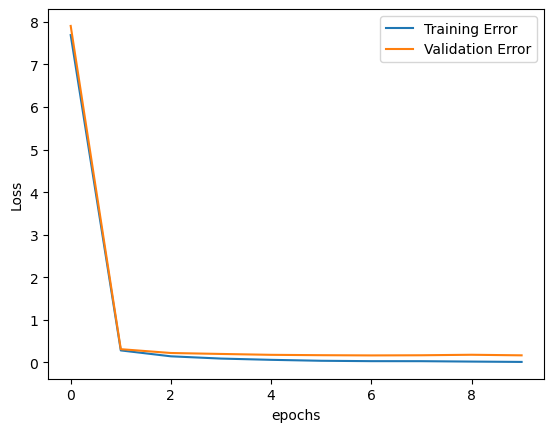

In [32]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# path to data
sys.path.append(os.path.join(os.getcwd(), "../../../data"))
from data.data_utils import load_dataset


def init_randn(m, n, rs=npr.RandomState(0)):
    """ init mxn matrix using small random normal
    """
    return 0.1 * rs.randn(m, n)


def init_xavier(m, n, rs=npr.RandomState(0)):
    """ TODO: init mxn matrix using Xavier intialization
    """
    matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            matrix[i][j] = rs
    return rs.normal(scale=np.sqrt(1/n), size=(m, n))


def init_net_params(layer_sizes, init_fcn, rs=npr.RandomState(0)):
    """ inits a (weights, biases) tuples for all layers using the intialize function (init_fcn)"""
    return [
        (init_fcn(m, n), np.zeros(n))  # weight matrix  # bias vector
        for m, n in zip(layer_sizes[:-1], layer_sizes[1:])
    ]


def relu(x):
    return np.maximum(0, x)


def neural_net_predict(params, inputs):
    """Implements a deep neural network for classification.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns normalized class log-probabilities."""
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = relu(outputs)
    return outputs - logsumexp(outputs, axis=1, keepdims=True) # alpha + log(sum(output - alpha))


def mean_log_like(params, inputs, targets):
    """ TODO: return the log-likelihood / the number of inputs 
    """
    # raise NotImplementedError("mean_log_like function not completed (see Q3).")
    return np.sum(np.multiply(targets, neural_net_predict(params, inputs))) / inputs.shape[0]


def accuracy(params, inputs, targets):
    """ return the accuracy of the neural network defined by params
    """
    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(neural_net_predict(params, inputs), axis=1)
    # print(predicted_class)
    return np.mean(predicted_class == target_class)


if __name__ == "__main__":
    # ----------------------------------------------------------------------------------
    # EXAMPLE OF HOW TO USE STARTER CODE BELOW
    # ----------------------------------------------------------------------------------

    # loading data
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset("mnist_small")

    # initializing parameters
    layer_sizes = [784, 600, 200, 10]
    params = init_net_params(layer_sizes, init_randn) # mxn random matrix for x

    # setting up training parameters
    num_epochs = 10
    learning_rate = 5e-3
    batch_size = 256 #256

    # Constants for batching
    num_batches = int(np.ceil(len(x_train) / batch_size))
    rind = np.arange(len(x_train))
    npr.shuffle(rind)

    def batch_indices(iter):
        idx = iter % num_batches
        return rind[slice(idx * batch_size, (idx + 1) * batch_size)]

    # Define training objective
    def objective(params, iter):
        # get indices of data in batch
        idx = batch_indices(iter)
        # print(idx)
        return -mean_log_like(params, x_train[idx], y_train[idx])

    # Get gradient of objective using autograd.

    objective_grad = grad(objective)

    print("     Epoch     |    Train accuracy  |       Validation accuracy  ")

    # Dictionary to store train/val history
    opt_history = {
        "train_nll": [],
        "val_nll": [],
    }

    def callback(params, iter, gradient):
        
        if iter % num_batches == 0:

            # record training & val. accuracy every epoch
            opt_history["train_nll"].append(-mean_log_like(params, x_train, y_train))
            opt_history["val_nll"].append(-mean_log_like(params, x_valid, y_valid))
            train_acc = accuracy(params, x_train, y_train)
            val_acc = accuracy(params, x_valid, y_valid)
            print("{:15}|{:20}|{:20}".format(iter // num_batches, train_acc, val_acc))

    # We will optimize using Adam (a variant of SGD that makes better use of
    # gradient information).
    opt_params = adam(
        objective_grad,
        params,
        step_size=learning_rate,
        num_iters=num_epochs * num_batches,
        callback=callback,
    )

    # Plotting the train and validation negative log-likelihood
    plt.plot(opt_history["train_nll"], label="Training Error")
    plt.plot(opt_history["val_nll"], label="Validation Error")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



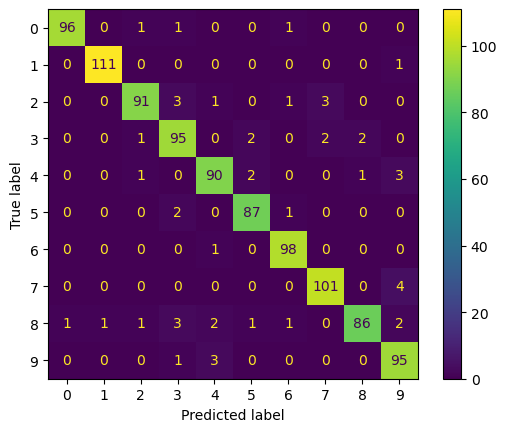

In [33]:
def confusion_mtx(params, inputs, targets):
    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(neural_net_predict(params, inputs), axis=1)
    # print(predicted_class)
    matrix = confusion_matrix(target_class, predicted_class)
    return matrix

cm = confusion_mtx(opt_params, x_valid, y_valid)
# print(cm)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_valid, axis=1), np.argmax(neural_net_predict(opt_params, x_valid), axis=1))
plt.show()